In [1]:
import pandas as pd

data = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
wigs = pd.read_csv("../database/gpwCompaniesLists/WIGs.csv")

In [408]:
data.loc[data["Ticker"] == "EKP"]

,Ticker,Data,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Rozliczenia międzyokresowe,Pasywa razem,Przepływy pieniężne z działalności operacyjnej,Amortyzacja,Przepływy pieniężne z działalności inwestycyjnej,CAPEX (niematerialne i rzeczowe),Przepływy pieniężne z działalności finansowej,Emisja akcji,Dywidenda,Przepływy pieniężne razem
1130,EKP,2007-04-10,7055.0,5210.0,0.0,2492.0,-647.0,612.0,226.0,-261.0,...,3374.0,9793.0,305.0,289.0,-270.0,270.0,1713.0,1713.0,0.0,1748.0
1131,EKP,2008-03-18,6405.0,4671.0,0.0,3402.0,-1668.0,313.0,216.0,-1571.0,...,569.0,17411.0,-8532.0,312.0,-2389.0,444.0,14447.0,14447.0,0.0,3526.0
1132,EKP,2009-04-30,6291.0,5295.0,0.0,3282.0,-2286.0,529.0,37.0,-1794.0,...,123.0,16100.0,-4944.0,396.0,-914.0,366.0,0.0,0.0,0.0,-5858.0
1133,EKP,2010-04-30,3882.0,5433.0,0.0,827.0,-2378.0,837.0,347.0,-1888.0,...,0.0,13358.0,-667.0,344.0,909.0,531.0,0.0,0.0,0.0,242.0
1134,EKP,2013-03-20,5123.0,3540.0,0.0,1072.0,511.0,3146.0,528.0,3129.0,...,0.0,62633.0,3141.0,142.0,-722.0,884.0,0.0,0.0,0.0,2419.0
1135,EKP,2014-03-20,4560.0,3303.0,0.0,947.0,310.0,3206.0,128.0,3388.0,...,0.0,53830.0,4050.0,67.0,6383.0,1440.0,-12698.0,0.0,0.0,-2265.0
1136,EKP,2015-03-18,4394.0,2685.0,0.0,932.0,777.0,1690.0,262.0,2205.0,...,0.0,54709.0,759.0,74.0,1186.0,343.0,-21.0,0.0,0.0,1924.0
1137,EKP,2016-03-15,4341.0,2477.0,0.0,669.0,1195.0,783.0,530.0,1448.0,...,0.0,54888.0,811.0,81.0,-3184.0,53.0,0.0,0.0,0.0,-2373.0
1138,EKP,2017-03-01,4421.0,2991.0,0.0,766.0,664.0,578.0,386.0,856.0,...,0.0,66386.0,824.0,73.0,-24081.0,227.0,26812.0,26812.0,0.0,3555.0
1139,EKP,2018-03-29,4593.0,4105.0,0.0,1378.0,-890.0,1841.0,1117.0,-166.0,...,0.0,93986.0,-437.0,159.0,-29126.0,1694.0,26800.0,0.0,0.0,-2763.0


## Założenia 

Dla każdego raportu (daty publikacji) pozyskujemy zestawienie wycen na każdy dzień

$t_0$ - data publikacji sprawozdania finansowego

$t_{-60}...t_{+15}$


In [456]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

class SmoothingFilters:
    @staticmethod
    def exponentialMovingAverage(x_data : np.ndarray, span : float = None, alpha : float = None) -> np.ndarray:
        return (pd.DataFrame({"x":x_data}).ewm(span=span, alpha=alpha).mean()["x"].to_numpy())

    @staticmethod
    def savgolFilter(x_data : np.ndarray, window_length : int, poly_order : int) -> np.ndarray:
        return savgol_filter(x_data, window_length, poly_order)


class IndexReturn:
    PATH_2_HISTORICAL = "../database/indexHistorical/"
    
    def __init__(self) -> None:
        self.historical_data : pd.DataFrame = None
        self.price_type :str = "Close"

    def readHistorical(self, wig_ticker : str) -> None:
        self.historical_data = pd.read_csv(f"{IndexReturn.PATH_2_HISTORICAL}{wig_ticker}.csv")
        # Cast to yahoo finance format 
        self.historical_data["Data"] = self.historical_data["Data"].apply(lambda x : pd.to_datetime(np.datetime64(x)))
        self.historical_data.set_index("Data", inplace=True, drop=True)
        self.historical_data.index.names = ['Date']
        self.historical_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    def getDailyReturn(self, t0 : np.datetime64, pre_offset : int, post_offset) -> np.ndarray:    
        post_historical = self.historical_data[(self.historical_data.index < t0)][-pre_offset-1:]
        pre_historical = self.historical_data[(self.historical_data.index >= t0)][:post_offset]
        historical = pd.concat([post_historical, pre_historical])

        historical_price = historical[self.price_type].to_numpy()

        historical_date   = historical.index[1:]
        historical_return = (historical_price[1:] - historical_price[:-1]) / historical_price[:-1]

        return pd.DataFrame({"IndexReturn": historical_return},
                            index=historical_date)
        
    def getHistorical(self) -> pd.DataFrame:
        return self.historical_data 
    

class CompanyReturn:
    POSTFIX = ".WA"
    PATH_2_WIGS = "../database/gpwCompaniesLists/WIGs.csv"

    def __init__(self):
        self.historical_data : pd.DataFrame = None
        self.price_type :str = "Close"
        self.wigs = pd.read_csv(CompanyReturn.PATH_2_WIGS)

    def readHistorical(self, company_ticker : str) -> None:
        yf_handler = yf.Ticker(company_ticker+CompanyReturn.POSTFIX)
        self.historical_data = yf_handler.history(period="max", interval="1d")
        self.historical_data.index = list(map(lambda x : np.datetime64(str(x)[:10]), 
                                              self.historical_data.index))

    def getDailyReturn(self, t0 : np.datetime64, pre_offset : int, post_offset) -> np.ndarray:
        if self.historical_data[(self.historical_data.index == t0)] == 0:
            print("ok")

        post_historical = self.historical_data[(self.historical_data.index < t0)][-pre_offset-1:]
        pre_historical = self.historical_data[(self.historical_data.index >= t0)][:post_offset]
        historical = pd.concat([post_historical, pre_historical])

        historical_price = historical[self.price_type].to_numpy()

        historical_date   = historical.index[1:]
        historical_return = (historical_price[1:] - historical_price[:-1]) / historical_price[:-1]

        return pd.DataFrame({"CompanyReturn": historical_return},
                            index=historical_date)
    
    def getIndexTick(self, company_ticker : str) -> str:
        return self.wigs.columns[self.wigs.isin([company_ticker]).any()].to_list()[0]

### Prepare differential value 

In [460]:
financial_reports = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
cr = CompanyReturn()

# Allocate memory 
columns_names = ["Index", "Pre7D", "Post7D", "Pre14D", "Post14D", "Pre21D", "Post21D"] 
database = []

DATE_OFFSET = 21
for row in financial_reports.itertuples():
    report_index, report_ticker, report_date = row[0:3]
    cr.readHistorical(report_ticker)
    cr_daily_return = cr.getDailyReturn(report_date, DATE_OFFSET, DATE_OFFSET)
    
    break
print(report_date)
cr_daily_return



ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Code example

In [415]:
TICKER = "EKP"
cr = CompanyReturn()
ir = IndexReturn()

t0 = np.datetime64("2019-03-05")
PRE_OFFSET = 21
POST_OFFSET = 21

cr.readHistorical(TICKER)
company_daily_return = cr.getDailyReturn(t0, PRE_OFFSET, POST_OFFSET)
ir.readHistorical(cr.getIndexTick(TICKER))
index_daily_return = ir.getDailyReturn(t0, PRE_OFFSET, POST_OFFSET) 

result = pd.merge(company_daily_return, index_daily_return, left_index=True, right_index=True, how='inner')

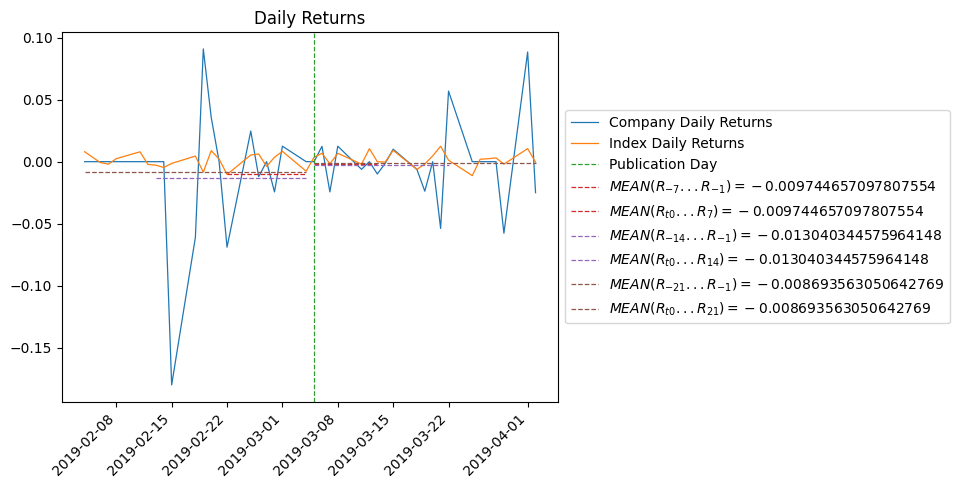

In [416]:
import matplotlib.pyplot as plt

N_PERIOD = 3
MEAN_PERIOD = np.arange(1, N_PERIOD+1) * POST_OFFSET//N_PERIOD

plt.plot(result.index, result["CompanyReturn"], linewidth=0.9, color = "C0", label= "Company Daily Returns")
plt.plot(result.index, result["IndexReturn"], linewidth=0.9, color = "C1",  label= "Index Daily Returns")
plt.axvline(x=t0, linestyle='--', linewidth=0.9, color = "C2", label= "Publication Day")
for i, period in enumerate(MEAN_PERIOD):
    # Before report publication
    before_period = result[result.index < t0][-period:]
    before_mean = np.mean(before_period["CompanyReturn"])
    plt.hlines(before_mean, before_period.index[0], before_period.index[-1], 
               linestyle='--', color=f"C{i+3}", linewidth=0.9, label= r"$MEAN(R_{-n1}...R_{-1})= val$".replace("n1", str(period)).replace("val", str(before_mean)))
    # After report publication
    after_period = result[result.index >= t0][:period]
    after_mean = np.mean(after_period["CompanyReturn"])
    plt.hlines(after_mean, after_period.index[0], after_period.index[-1], 
               linestyle='--', color=f"C{i+3}", linewidth=0.9, label= r"$MEAN(R_{t0}...R_{n1})= val$".replace("n1", str(period)).replace("val", str(before_mean)))
plt.xticks(rotation=45, ha='right')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Daily Returns")
plt.show()

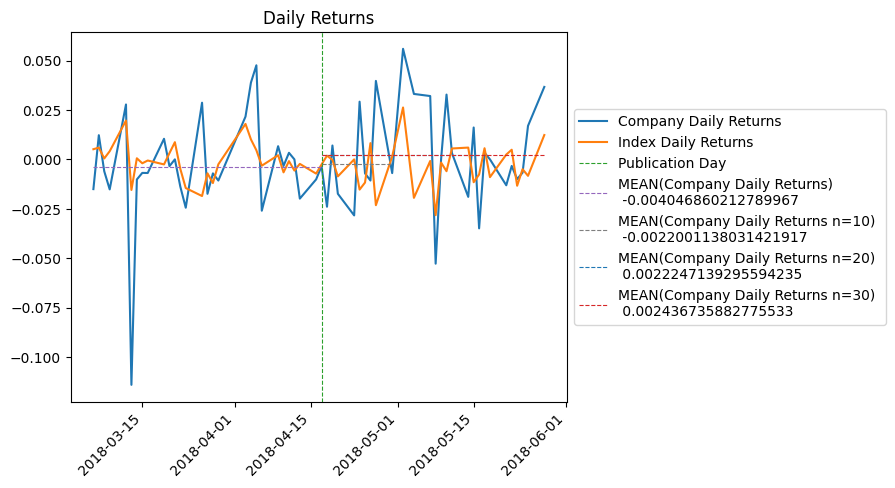

In [376]:
import matplotlib.pyplot as plt

N_PERIOD = 3
MEAN_POST_PERIOD = np.arange(1, N_PERIOD+1) * POST_OFFSET//N_PERIOD

plt.plot(result.index, result["CompanyReturn"], color = "C0", label= "Company Daily Returns")
plt.plot(result.index, result["IndexReturn"], color = "C1",  label= "Index Daily Returns")
plt.axvline(x=t0, color="C2", linestyle='--', linewidth=0.8, label= "Publication Day")
period_mean = np.mean(result[result.index < t0]["CompanyReturn"])
plt.hlines(period_mean, result.index[0], t0, color="C4", 
           linestyle='--', linewidth=0.8, label= f"MEAN(Company Daily Returns) \n {period_mean}")
for i, period in enumerate(MEAN_POST_PERIOD):
    period_result = result[result.index >= t0][:period]
    period_mean = np.mean(period_result["CompanyReturn"])
    plt.hlines(period_mean, period_result.index[0], period_result.index[-1], 
               linestyle='--', color=f"C{i*3+7}", linewidth=0.8, label= f"MEAN(Company Daily Returns n={period}) \n {period_mean}")

plt.xticks(rotation=45, ha='right')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Daily Returns")
plt.show()


In [307]:
result[result.index >= t0]

UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>) -> None

In [261]:
MEAN_POST_PERIOD

array([10, 20, 30])

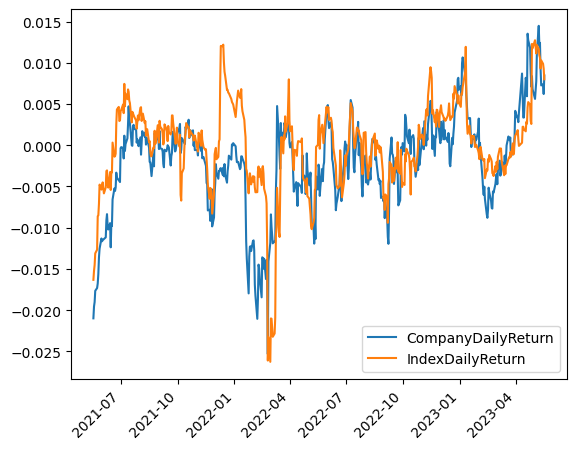

In [97]:
plt.plot(result.index, result["CompanyReturn"].ewm(span=30, adjust=False).mean().to_list(), label= "CompanyDailyReturn")
plt.plot(result.index, result["IndexReturn"].ewm(span=30, adjust=False).mean().to_list(),  label= "IndexDailyReturn")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()



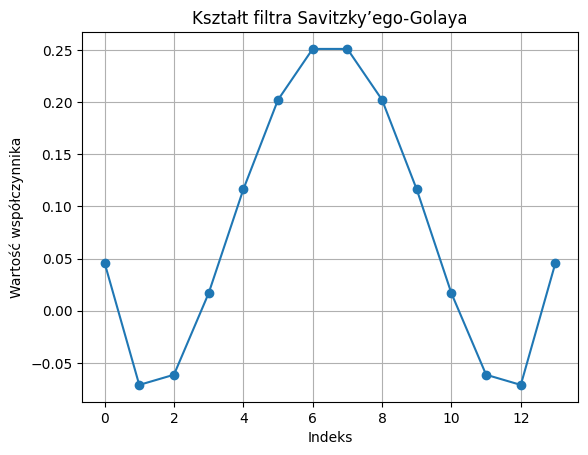

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_coeffs, savgol_filter

# Parametry filtra
window_length = 14  # Długość okna, musi być nieparzysta
polyorder = 4       # Rząd wielomianu

# Oblicz współczynniki filtra
coeffs = savgol_coeffs(window_length, polyorder)

# Wizualizacja kształtu filtra
plt.plot(coeffs, marker='o')
plt.title('Kształt filtra Savitzky’ego-Golaya')
plt.xlabel('Indeks')
plt.ylabel('Wartość współczynnika')
plt.grid(True)
plt.show()

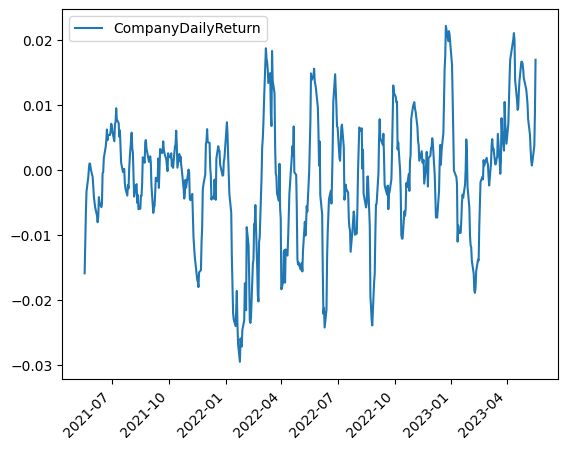

In [94]:
plt.plot(result.index, savgol_filter(result["CompanyReturn"], 30, 5), label= "CompanyDailyReturn")
#plt.plot(result.index, result["CompanyReturn"], label= "RawCompanyDailyReturn")
#plt.plot(result.index, result["IndexReturn"].ewm(span=12, adjust=False).mean().to_list(),  label= "IndexDailyReturn")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [347]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
x = index_daily_return.reshape(-1, 1)
y = daily_return.reshape(-1, 1)
model.fit(x,y)
y_pred = model.predict(x)
print('coefficients: ', model.coef_)
print('intercept: ', model.intercept_)
print('Root Mean Squared Error (RMSE): %.2f'% np.sqrt(mean_squared_error(y, y_pred)))
print('Coefficient of determination: %.2f'% r2_score(y, y_pred))

coefficients:  [[0.90695405]]
intercept:  [-0.00081518]
Root Mean Squared Error (RMSE): 0.02
Coefficient of determination: 0.66
